# Portfolio Optimization: Stock Combination of LQ45 Index according to Markowitz's Modern Portfolio Theorem with Monte Carlo Technique and Scipy Optimizer
---
The following Optimization Model is tested to find out which stocks combination of LQ45 index that will produce a portfolio with optimal return and volatility. The data used in this model is the historical data with a range of 5 years.

The Hyphotesis:
- The more risk or volatile the portfolio, the more profit can you expect from it
- The diversification of stocks can be use to lower the risk.

Problem:
- Which of the combination of LQ45 index that will produce the most optimal return and volatility
- How much weight of each stock should be used to make the portfolio

---
Model and Anlyze by:\
    - <a href="https://www.linkedin.com/in/willy-darmawan/">**Ilham Willy Darmawan**</a>



## Importing the modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Set the Time Range (The last 5 Years)

In [4]:
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

## Gathering the LQ45 Index datas
The LQ45 index is used with the assumption of the top 45 stocks with the highest liquidity and transaction volume.

In [5]:
data_index = pd.read_csv(r"./data2/index LQ45.csv")
stocks = data_index.dropna()["Kode"]

## Taking historical data from Yahoo Finance

In [6]:
import yfinance as yf

data = {}
for stock in stocks:
    ticker = yf.Ticker(f"{stock}.JK")
    data[stock] = ticker.history(start=start_date, end=end_date)["Close"]

### Saving to csv, dan dropping Null Data

In [7]:
df = pd.DataFrame(data).dropna(axis = 1)
df.to_csv(r"./data2/data.csv")

### Checking Data

In [8]:
df.head()

,ACES,ADRO,AKRA,AMRT,ANTM,ARTO,ASII,BBCA,BBNI,BBRI,...,MDKA,MEDC,PGAS,PTBA,SIDO,SMGR,TLKM,TOWR,UNTR,UNVR
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-23 00:00:00+07:00,1518.966553,606.462158,616.371704,817.149475,875.025940,103.568031,4869.215332,5386.481445,3299.087158,2994.479980,...,1214.623535,569.914734,1325.485718,1084.402222,476.883636,11652.229492,3461.631348,631.529663,12686.886719,7691.873535
2019-08-26 00:00:00+07:00,1562.119019,626.025574,625.548523,821.845703,887.957336,103.568031,4869.215332,5381.989258,3245.003662,2987.140381,...,1204.867432,547.418091,1387.051880,1049.561890,478.870667,11473.992188,3422.115234,618.463562,12454.807617,7700.266113
2019-08-27 00:00:00+07:00,1544.858154,631.615051,624.019043,826.541992,879.336365,103.568031,4832.187500,5395.466309,3277.453125,3082.552490,...,1156.087402,543.668640,1448.618164,1053.916992,464.961578,11496.271484,3461.631348,614.108154,12810.658203,7935.261719
2019-08-28 00:00:00+07:00,1536.227539,617.641235,651.549316,831.238281,905.199158,103.568031,4776.645020,5386.481445,3288.270020,3075.213623,...,1180.477417,562.415894,1419.645874,1049.561890,474.896606,11540.829102,3453.728271,605.397339,12934.432617,8035.972656
2019-08-29 00:00:00+07:00,1506.020874,614.846497,650.019836,845.327026,909.509705,103.568031,4758.129883,5395.466309,3255.820312,3082.552490,...,1204.867432,551.167480,1383.430420,1049.561890,466.948486,11674.509766,3461.631348,627.174133,12795.186523,8031.776367


## Generate portfolio of the stock combination
In this case, we will use 3 combinations of 45 stocks in total of LQ45 index.\
\
Formula:
$$
  C_{(r,n)} = \frac{n!}{r! (n-r)!}
$$

In [9]:
from itertools import combinations

numOfStock = 3
portfolios = [stock for stock in combinations(df.columns, numOfStock)]


#### Formula use:
- Stock Return:
$$
    R_{i, t} = log(\frac{P_{t}}{P_{t-1}})
$$
- Expected Stock Return:
$$
    E(R_{i}) = \frac {\sum \limits _{t=1} ^{n} R_{i, t}} {n} 
$$
- Expected Return Portfolio:
$$
    E(R_{p}) = W^{T} . E(R_{i})
$$
- Expected Volatility:
$$
    \sigma _{p} ^{2} = \sqrt {\sum \limits _{i=1} ^{n} \sum \limits _{j=1} ^{n} W_{i, t} . W_{i, j} . Cov(r_{i}, r_{j})}
$$
- Sharpe Ratio:
$$
    SR = \frac{E(R_{p})}{\sigma _{p} ^{2}}
$$

## MONTE CARLO SIMULATION WITH n=1000

In [ ]:
numOfSimulation     = 1000
weights             = np.zeros((numOfSimulation, numOfStock))
expected_return_p   = np.zeros(numOfSimulation)
expected_volatility = np.zeros(numOfSimulation)
sharpe_ratio        = np.zeros(numOfSimulation)

In [ ]:
result = {x: {} for x in range(len(portfolios))}
for i, portfolio in enumerate(portfolios):
    data = df.filter(items=portfolio) # type: ignore
    log_ret = np.log(data/data.shift(1))

    for j in range(numOfSimulation):
        w = np.array(np.random.random(numOfStock)) 
        w = w / np.sum(w)
        weights[j,:] = w
        
        expected_return_p[j] = np.sum(log_ret.mean() * w)*252
        expected_volatility[j] = np.sqrt(
            np.dot(
                    w.T, np.dot(
                        np.dot(
                            log_ret.cov(), 252), w) # type: ignore
                )
            )
        sharpe_ratio[j] = expected_return_p[j] / expected_volatility[j]
    
    maxIndex = sharpe_ratio.argmax()

    result[i]["portfolio"]              = portfolio
    result[i]["weight"]                 = weights[maxIndex,:].tolist()
    result[i]["expected_return"]        = expected_return_p[maxIndex]
    result[i]["expected_volatility"]    = expected_volatility[maxIndex]
    
    print(i, portfolio, weights[maxIndex,:])

## SCIPY OPTIMIZER TO CALCULATE WEIGHT

In [10]:
from scipy.optimize import minimize

def get_R_V_SR(w, eri, cov):
    w = np.array(w)
    R = np.sum(eri*w)
    V = np.sqrt(
        np.dot(
            w.T, np.dot(cov, w)
        )
    )

    sr = R/V

    return np.array([R, V, sr])



In [11]:
result = {x: {} for x in range(len(portfolios))}
constraints = ({"type":"eq", "fun": lambda x : np.sum(x)-1})

for i, portfolio in enumerate(portfolios):
    data = df.filter(items=portfolio) # type: ignore
    log_ret = np.log(data/data.shift(1))

    weight_optimized = minimize(
        lambda w: get_R_V_SR(w, log_ret.mean(), log_ret.cov())[-1]*-1,
        [1/numOfStock for _ in range(numOfStock)],
        method="SLSQP",
        bounds = tuple((0, 1) for _ in range(numOfStock)),
        constraints=constraints)
    
    result[i]["portfolio"]              = portfolio
    result[i]["weight"]                 = weight_optimized.x
    result[i]["expected_return"]        = np.sum(log_ret.mean() * weight_optimized.x)*252
    result[i]["expected_volatility"]    = np.sqrt(
            np.dot(
                    weight_optimized.x, np.dot(
                        np.dot(
                            log_ret.cov(), 252), weight_optimized.x) # type: ignore
                )
            )


## Portfolio Result

### Tidy up

In [12]:
result = pd.DataFrame(data=result).T
result["weight"] = result["weight"].apply(lambda i: list(map(lambda x: round(x*100, 2), i)))
result["expected_return"] = result["expected_return"].astype(float)
result["expected_volatility"] = result["expected_volatility"].astype(float)
result["sharpe_index"] = result["expected_return"].div(result["expected_volatility"])

In [13]:
result.head()

,portfolio,weight,expected_return,expected_volatility,sharpe_index
0,"(ACES, ADRO, AKRA)","[0.0, 74.43, 25.57]",0.307815,0.379019,0.812135
1,"(ACES, ADRO, AMRT)","[0.0, 51.8, 48.2]",0.308683,0.311371,0.991365
2,"(ACES, ADRO, ANTM)","[0.0, 100.0, 0.0]",0.349978,0.446681,0.783508
3,"(ACES, ADRO, ARTO)","[0.0, 62.82, 37.18]",0.477667,0.424952,1.124049
4,"(ACES, ADRO, ASII)","[0.0, 100.0, 0.0]",0.349978,0.446681,0.783508


### Plotting the result

<Axes: >

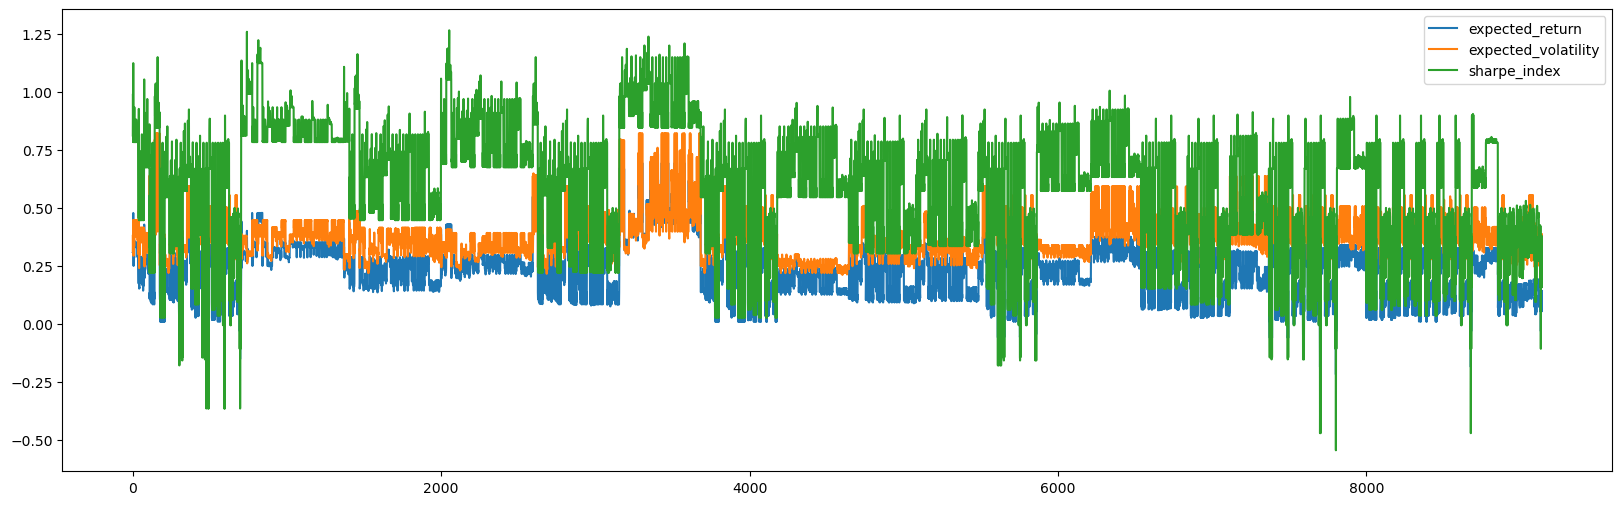

In [27]:
result.plot(figsize=(20, 6))

### Expected Return and Expected Volatility has a positive correlation
This means that the higher the return from the portfolio, the higher the volatility the portfolio has.
\
One of the optimal portfolio parameters is the **Sharpe Index**, which divide the return by the risk.

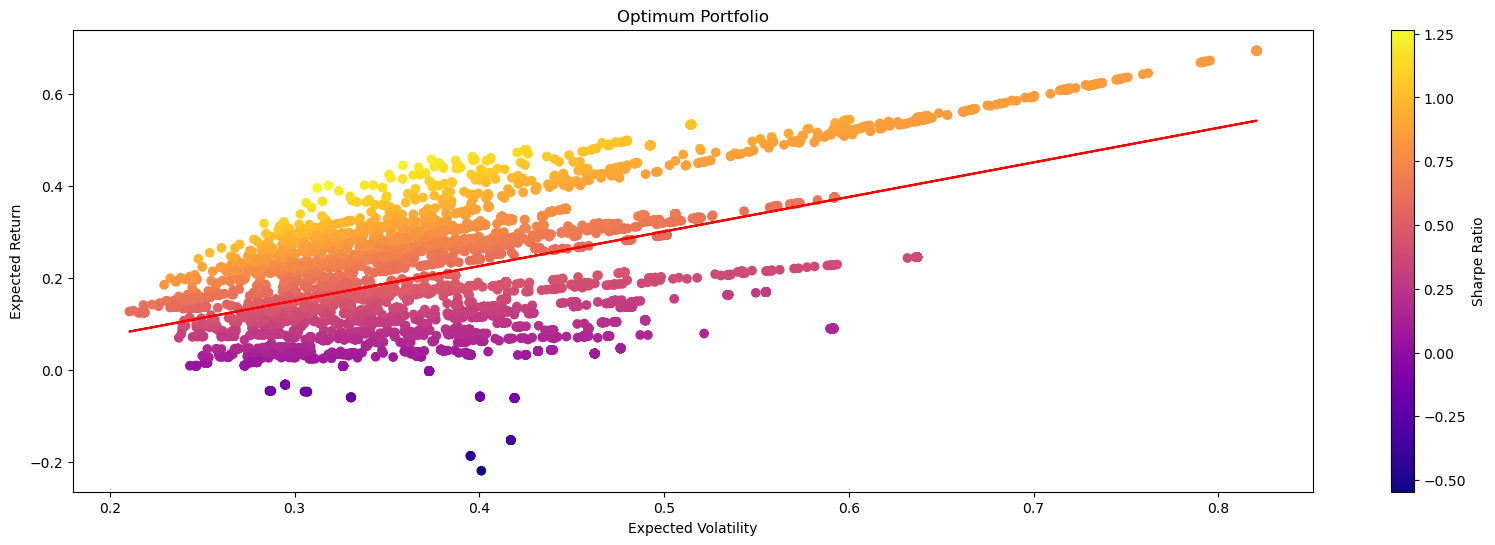

In [15]:
from scipy.stats import linregress

x = result["expected_volatility"]
y = result["expected_return"]
slope, intercept, r, p, std_err = linregress(x, y)

plt.figure(figsize=(20, 6))
plt.scatter(x, y, c=result["sharpe_index"], cmap="plasma")
plt.plot(x, list(map(lambda i: slope * i + intercept, x)), c="red")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")
plt.title("Optimum Portfolio")
plt.show()

In [16]:
from IPython.display import display, Markdown

display(Markdown("The Correlation of Expected Volatility and Expected Return later can be describe as positive correlation with:"))
display(Markdown(f"**R**: {round(r*100, 2)}%"))
display(Markdown(f"**Std Error**: {round(std_err*100, 2)}%"))
display(Markdown(f"**P Value**: {round(p, 4)}"))
display(Markdown(f"The **P value** of {round(p, 4)} can be explain that the Expected Volatility has statistically **significant correlation**"))


The Correlation of Expected Volatility and Expected Return later can be describe as positive correlation with:

**R**: 58.26%

**Std Error**: 1.1%

**P Value**: 0.0

The **P value** of 0.0 can be explain that the Expected Volatility has statistically **significant correlation**

The data we have can be sorted based on the **sharpe index**, to obtain a portfolio combination with optimal return and volatility.

In [17]:
result.sort_values("sharpe_index", ascending=False)

,portfolio,weight,expected_return,expected_volatility,sharpe_index
2052,"(AMRT, ARTO, ITMG)","[33.68, 24.48, 41.84]",0.395204,0.312233,1.265734
740,"(ADRO, AMRT, ARTO)","[39.13, 36.88, 23.99]",0.400772,0.318257,1.259271
3344,"(ARTO, BRIS, ITMG)","[29.11, 22.93, 47.96]",0.444189,0.358636,1.238553
814,"(ADRO, ARTO, BRIS)","[45.16, 29.49, 25.35]",0.457535,0.374091,1.223056
3578,"(ARTO, ISAT, ITMG)","[28.77, 22.27, 48.96]",0.424537,0.351096,1.209178
...,...,...,...,...,...
696,"(ACES, SMGR, UNVR)","[100.0, 0.0, 0.0]",-0.152478,0.417024,-0.365633
7703,"(GGRM, INTP, UNVR)","[0.0, 100.0, 0.0]",-0.186555,0.395236,-0.472009
7699,"(GGRM, INTP, SMGR)","[0.0, 100.0, 0.0]",-0.186555,0.395236,-0.472009
8677,"(INTP, SMGR, UNVR)","[100.0, 0.0, 0.0]",-0.186555,0.395236,-0.472009


## Analyzing the result

### Analyzing the 6 most optimal portfolios
From the test results, a portfolio was obtained from a stocks combination of:\
AMRT: 34%\
ARTO: 24%\
ITMG: 42%\
which gives us 39% of annual return, with 31% of expected volatility

In [18]:
optimal_portfolios = result.sort_values("sharpe_index", ascending=False)[:6]
optimal_portfolios

,portfolio,weight,expected_return,expected_volatility,sharpe_index
2052,"(AMRT, ARTO, ITMG)","[33.68, 24.48, 41.84]",0.395204,0.312233,1.265734
740,"(ADRO, AMRT, ARTO)","[39.13, 36.88, 23.99]",0.400772,0.318257,1.259271
3344,"(ARTO, BRIS, ITMG)","[29.11, 22.93, 47.96]",0.444189,0.358636,1.238553
814,"(ADRO, ARTO, BRIS)","[45.16, 29.49, 25.35]",0.457535,0.374091,1.223056
3578,"(ARTO, ISAT, ITMG)","[28.77, 22.27, 48.96]",0.424537,0.351096,1.209178
3318,"(ARTO, BMRI, ITMG)","[27.4, 28.71, 43.89]",0.388869,0.323970,1.200325


In [19]:
stock_list = []
for p in optimal_portfolios["portfolio"].values:
    for s in p:
        stock_list.append(s)

Of these 6 stocks, ARTO has the highest frequency of fluctuations.\
The rate of change in ARTO prices shows that this stock is a volatile stock.

<Axes: title={'center': 'Percentage Change'}, xlabel='Date'>

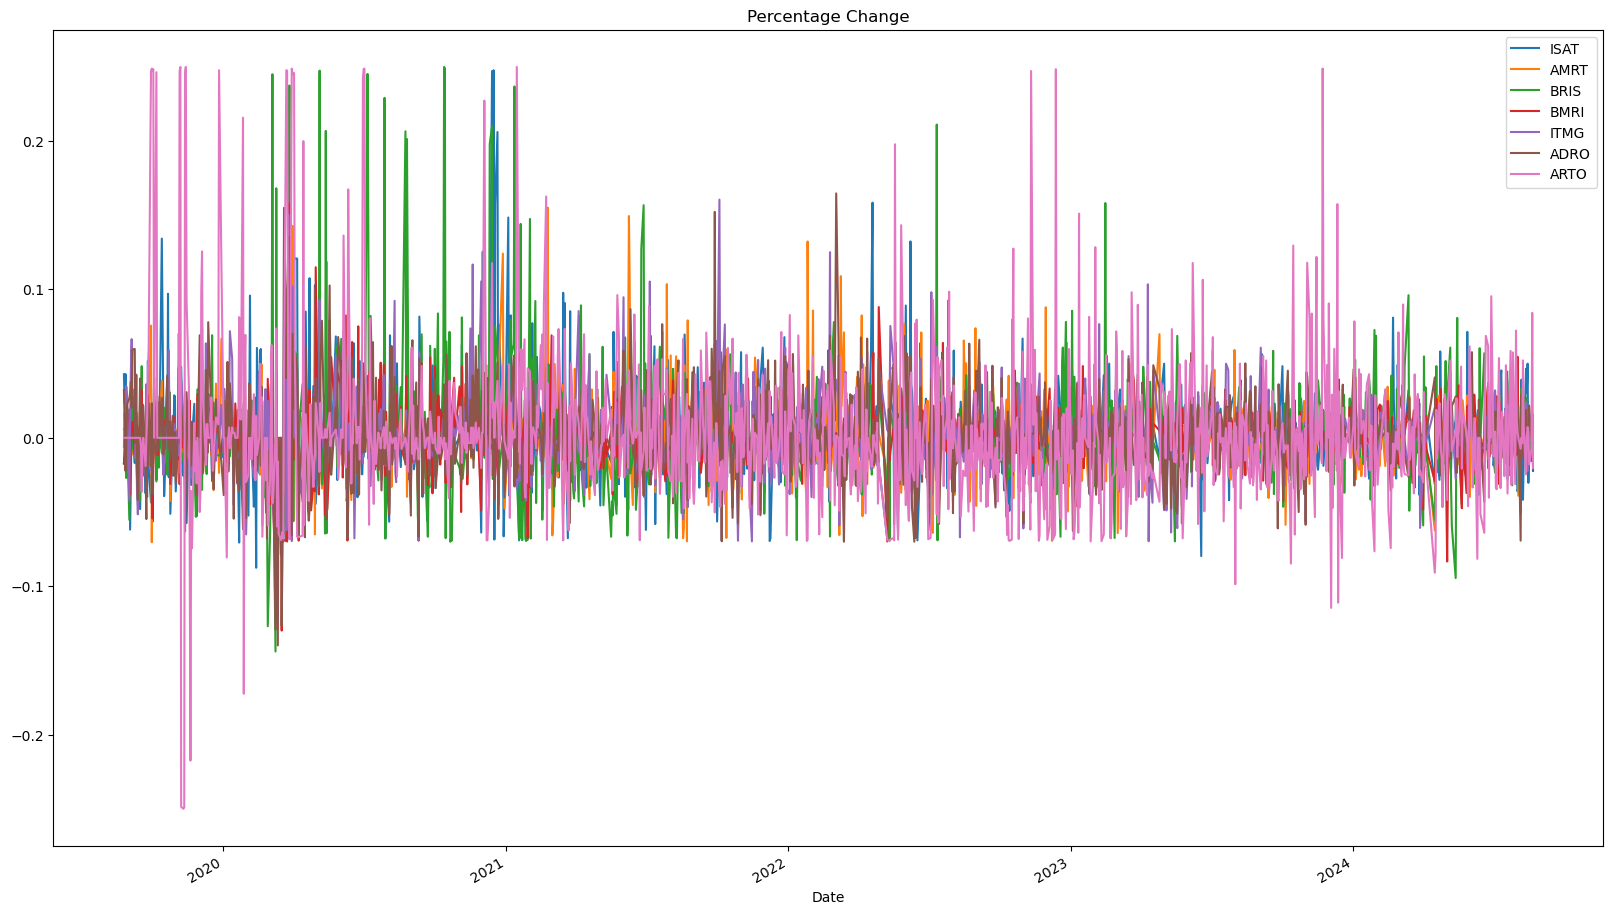

In [20]:
portfolio1 = df.filter(items=list(set(stock_list)))

portfolio1.pct_change().plot(figsize=(20, 12), title="Percentage Change")

<Axes: title={'center': 'Percentage Change'}, xlabel='Date'>

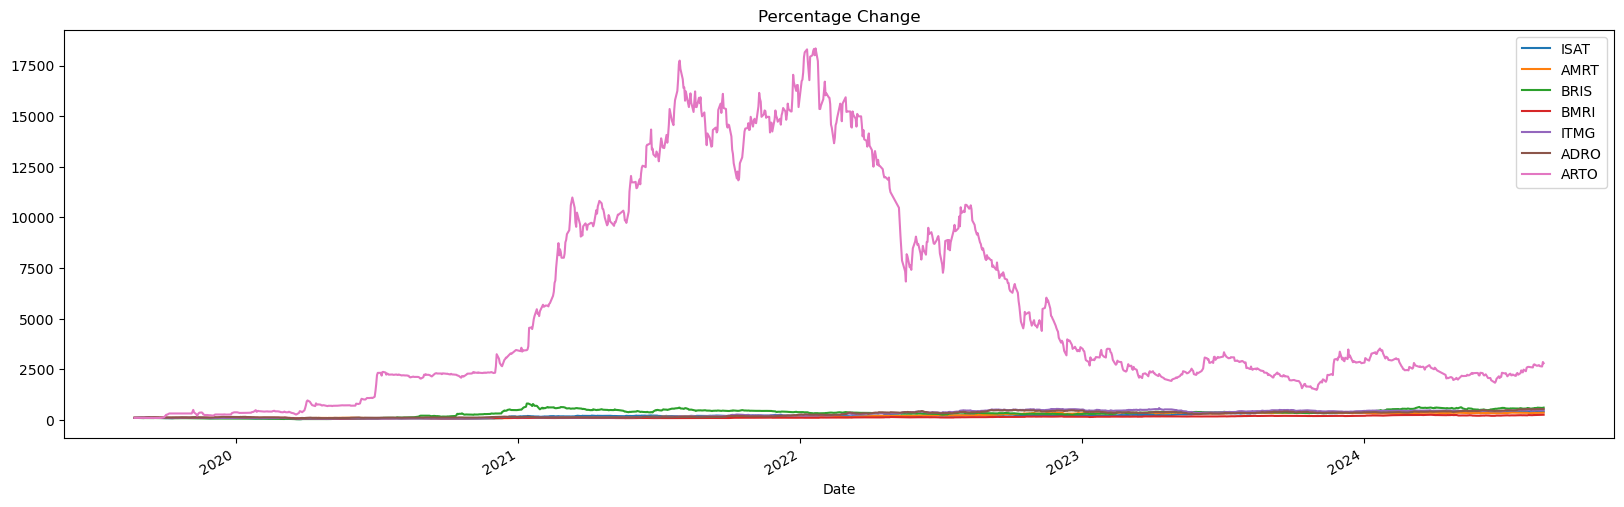

In [21]:
(portfolio1 * 100 / portfolio1.iloc[0]).plot(figsize=(20, 6), title="Percentage Change")

Covariance (Correlation Coefficient) of the 6 stocks we chose shows some stocks are distributed with the same trend. The combination of these stocks produces an optimal portfolio.

array([[<Axes: xlabel='ISAT', ylabel='ISAT'>,
        <Axes: xlabel='AMRT', ylabel='ISAT'>,
        <Axes: xlabel='BRIS', ylabel='ISAT'>,
        <Axes: xlabel='BMRI', ylabel='ISAT'>,
        <Axes: xlabel='ITMG', ylabel='ISAT'>,
        <Axes: xlabel='ADRO', ylabel='ISAT'>,
        <Axes: xlabel='ARTO', ylabel='ISAT'>],
       [<Axes: xlabel='ISAT', ylabel='AMRT'>,
        <Axes: xlabel='AMRT', ylabel='AMRT'>,
        <Axes: xlabel='BRIS', ylabel='AMRT'>,
        <Axes: xlabel='BMRI', ylabel='AMRT'>,
        <Axes: xlabel='ITMG', ylabel='AMRT'>,
        <Axes: xlabel='ADRO', ylabel='AMRT'>,
        <Axes: xlabel='ARTO', ylabel='AMRT'>],
       [<Axes: xlabel='ISAT', ylabel='BRIS'>,
        <Axes: xlabel='AMRT', ylabel='BRIS'>,
        <Axes: xlabel='BRIS', ylabel='BRIS'>,
        <Axes: xlabel='BMRI', ylabel='BRIS'>,
        <Axes: xlabel='ITMG', ylabel='BRIS'>,
        <Axes: xlabel='ADRO', ylabel='BRIS'>,
        <Axes: xlabel='ARTO', ylabel='BRIS'>],
       [<Axes: xlabel='ISAT', y

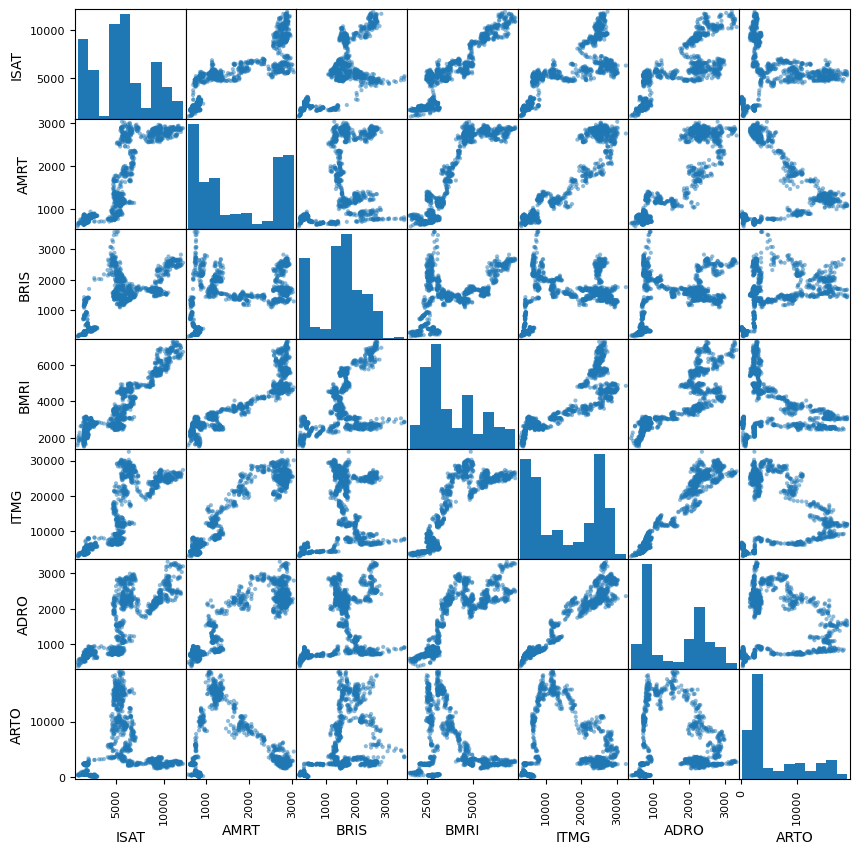

In [22]:
from pandas.plotting import scatter_matrix

scatter_matrix(portfolio1, figsize=(10,10))

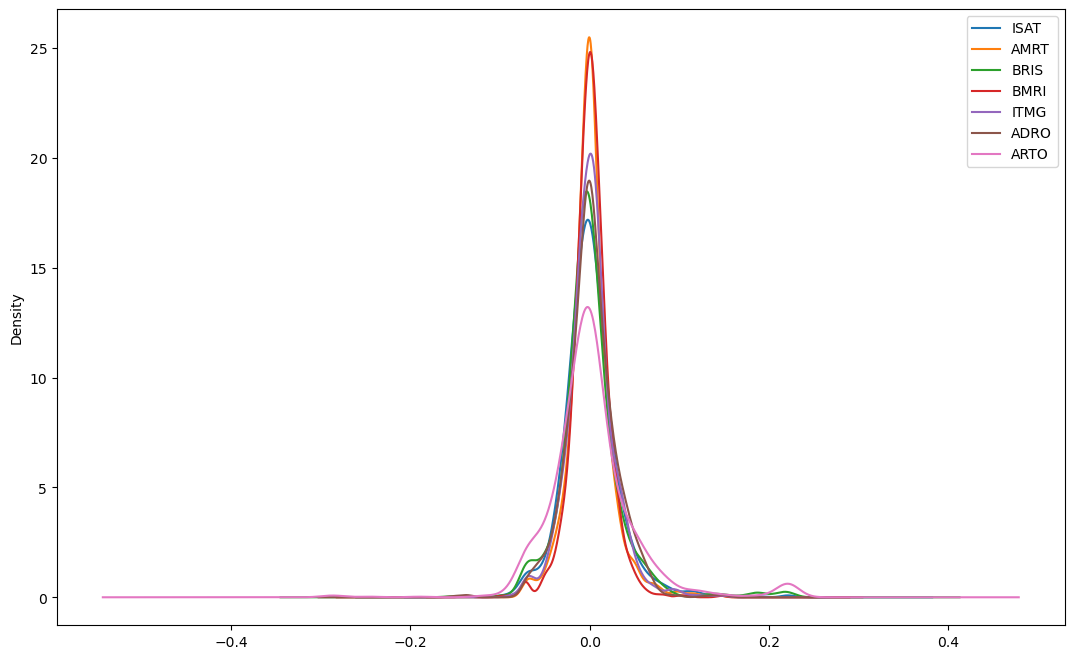

In [23]:
log_p = np.log(portfolio1/portfolio1.shift(1))
for stock in log_p:
    log_p[stock].plot(kind="kde", label=stock, figsize=(13,8))
plt.legend()
plt.show()

## Conclusion

In [24]:
display(Markdown("Top 5 Portfolios from LQ45 with Optimal Return and Volatility"))

for i in range(5):
    display(Markdown(f"{i+1}. Stocks Combination **{optimal_portfolios[i:i+1]["portfolio"].to_string()[-18:]}**</br>"))
    display(Markdown(f"- {optimal_portfolios[i:i+1]["portfolio"].to_list()[0][0]}: **{optimal_portfolios[i:i+1]["weight"].to_list()[0][0]}%**</br>"))
    display(Markdown(f"- {optimal_portfolios[i:i+1]["portfolio"].to_list()[0][1]}: **{optimal_portfolios[i:i+1]["weight"].to_list()[0][1]}%**</br>"))
    display(Markdown(f"- {optimal_portfolios[i:i+1]["portfolio"].to_list()[0][2]}: **{optimal_portfolios[i:i+1]["weight"].to_list()[0][2]}%**</br>"))
    display(Markdown(f"- Expected Return per year: **{round(optimal_portfolios[i:i+1]["expected_return"].values[0]*100,2)}%**</br>"))
    display(Markdown(f"- Expected Volatility per year: **{round(optimal_portfolios[i:i+1]["expected_volatility"].values[0]*100,2)}%**</br></br>"))


Top 5 Portfolios from LQ45 with Optimal Return and Volatility

1. Stocks Combination **(AMRT, ARTO, ITMG)**</br>

- AMRT: **33.68%**</br>

- ARTO: **24.48%**</br>

- ITMG: **41.84%**</br>

- Expected Return per year: **39.52%**</br>

- Expected Volatility per year: **31.22%**</br></br>

2. Stocks Combination **(ADRO, AMRT, ARTO)**</br>

- ADRO: **39.13%**</br>

- AMRT: **36.88%**</br>

- ARTO: **23.99%**</br>

- Expected Return per year: **40.08%**</br>

- Expected Volatility per year: **31.83%**</br></br>

3. Stocks Combination **(ARTO, BRIS, ITMG)**</br>

- ARTO: **29.11%**</br>

- BRIS: **22.93%**</br>

- ITMG: **47.96%**</br>

- Expected Return per year: **44.42%**</br>

- Expected Volatility per year: **35.86%**</br></br>

4. Stocks Combination **(ADRO, ARTO, BRIS)**</br>

- ADRO: **45.16%**</br>

- ARTO: **29.49%**</br>

- BRIS: **25.35%**</br>

- Expected Return per year: **45.75%**</br>

- Expected Volatility per year: **37.41%**</br></br>

5. Stocks Combination **(ARTO, ISAT, ITMG)**</br>

- ARTO: **28.77%**</br>

- ISAT: **22.27%**</br>

- ITMG: **48.96%**</br>

- Expected Return per year: **42.45%**</br>

- Expected Volatility per year: **35.11%**</br></br>

Investment decisions should be considered based on the risks and volatility involved. With the right weighting and stock combination optimization, a portfolio can have an appropriate rate of return with minimum risk.